<a href="https://colab.research.google.com/github/pourmand1376/.dotfiles/blob/main/NLP_ParsBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jun 30 22:13:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# https://drive.google.com/file/d/18l4Ca8KBkCo0-Eelt6dxAo6ve0lGEGuJ/view?usp=sharing
!gdown 18l4Ca8KBkCo0-Eelt6dxAo6ve0lGEGuJ

Downloading...
From: https://drive.google.com/uc?id=18l4Ca8KBkCo0-Eelt6dxAo6ve0lGEGuJ
To: /content/dataset_annotated_sentiment.json
100% 1.74M/1.74M [00:00<00:00, 154MB/s]


In [3]:
!pip install hazm -Uqq
!pip install transformers -Uqq
!pip install pytorch-lightning -Uqq
!pip install torchmetrics -Uqq
!pip install lightning-transformers -Uqq

     |████████████████████████████████| 316 kB 4.8 MB/s 
     |████████████████████████████████| 1.4 MB 56.1 MB/s 
     |████████████████████████████████| 233 kB 51.9 MB/s 
     |████████████████████████████████| 4.4 MB 4.9 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 596 kB 68.5 MB/s 
     |████████████████████████████████| 6.6 MB 40.3 MB/s 
     |████████████████████████████████| 585 kB 4.9 MB/s 
     |████████████████████████████████| 140 kB 69.2 MB/s 
     |████████████████████████████████| 419 kB 60.9 MB/s 
     |████████████████████████████████| 1.1 MB 59.4 MB/s 
     |████████████████████████████████| 271 kB 55.8 MB/s 
     |████████████████████████████████| 144 kB 68.7 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 76 kB 3.1 MB/s 
     |████████████████████████████████| 1.0 MB 25.0 MB/s 
     |████████████████████████████████| 1.2 MB 57.8 MB/s 
     |███████████████

In [4]:
from hazm import Normalizer

normalizer = Normalizer()

In [5]:
id2label = {
    1 : 'خنثی',
    2: 'مثبت',
    0 : 'منفی'
}
label2id = {value:key for (key,value) in id2label.items()}

def read_data_convert(data,voting):
    """
    this function gets a split and returns its text and labels
    """

    text_array = []
    label_array = []
    if voting:
        for item in data:
            label_item = item['annotations']
            pos = label_item.count('مثبت')
            neg = label_item.count('منفی')
            neutral = label_item.count('خنثی')
            if pos == neg == neutral:
                continue
            text_array.append(normalizer.normalize(item['text']))
            number_label = "مثبت" if pos > 1 else ("منفی" if neg > 1 else "خنثی")
            label_array.append(number_label)
    else:
        for item in data:
            for label in item['annotations']:
                if isinstance(label, str):  
                    text_array.append( normalizer.normalize(item['text']))
                    label_array.append(label)

    label_array = list(map(lambda x: label2id[x], label_array))
    return text_array, label_array

In [6]:
#!pip install ipdb -Uqq
#%pdb on

In [7]:
from transformers import pipeline
from transformers import BertTokenizer, BertModel

model_name_or_path = "HooshvareLab/bert-fa-zwnj-base"

tokenizer = BertTokenizer.from_pretrained(model_name_or_path)



Downloading:   0%|          | 0.00/416k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/292 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

In [8]:
import json
from pathlib import Path
dataset = json.loads(Path('dataset_annotated_sentiment.json').read_text())

train_texts, train_labels = read_data_convert(dataset['train'],voting=True)
val_texts, val_labels = read_data_convert(dataset['eval'],voting=True)
test_texts, test_labels = read_data_convert(dataset['test'],voting=True)

train_encodings = tokenizer(train_texts, truncation=True, padding=True,max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True,max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True,max_length=256)

In [9]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)



In [10]:
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from torchmetrics import AUROC

BERT_MODEL_NAME = "HooshvareLab/bert-fa-zwnj-base"


from transformers import TrainingArguments, Trainer,AutoModelForSequenceClassification
from torch.utils.data import DataLoader

model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME,
                                                           num_labels=3,
                                                           label2id=label2id,
                                                           id2label=id2label)
model.config

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/b

BertConfig {
  "_name_or_path": "HooshvareLab/bert-fa-zwnj-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "\u0645\u0646\u0641\u06cc",
    "1": "\u062e\u0646\u062b\u06cc",
    "2": "\u0645\u062b\u0628\u062a"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "\u062e\u0646\u062b\u06cc": 1,
    "\u0645\u062b\u0628\u062a": 2,
    "\u0645\u0646\u0641\u06cc": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 42000
}

In [21]:
# you should freeze all parameters except classifier
# otherwise, you will be training the BERT!!
for param in model.bert.parameters():
    param.requires_grad = False

In [32]:
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchmetrics
import torch
import torchmetrics.functional as TF
from torchmetrics import ConfusionMatrix

# important
from torch.utils.data import WeightedRandomSampler

class LiteModel(pl.LightningModule):
    def __init__(self,model, train_dataset, val_dataset, test_dataset, batch_size,num_classes):
        super(LiteModel, self).__init__()
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_classes = num_classes

        self.train_acc = torchmetrics.Accuracy()
        self.train_f1 = torchmetrics.F1Score(num_classes=num_classes)
        self.train_auroc = torchmetrics.AUROC(num_classes=num_classes)

        self.val_acc = torchmetrics.Accuracy()
        self.val_f1 = torchmetrics.F1Score(num_classes=num_classes)
        self.val_auroc = torchmetrics.AUROC(num_classes=num_classes)
        
        self.test_acc = torchmetrics.Accuracy()
        self.test_f1= torchmetrics.F1Score(num_classes=num_classes)
        self.test_auroc = torchmetrics.AUROC(num_classes=num_classes)

        self.confusion_matrix = ConfusionMatrix(num_classes=num_classes)


    def forward(self, x):
        return model(**x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2,verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': lr_scheduler,
            'monitor': 'val_loss'
        }

    def training_step(self, batch, batch_idx):
        output= self(batch)

        softmax = output.logits.softmax(dim=1)
        y_pred = torch.argmax(softmax, dim=1)
        y_target = batch['labels']

        acc = self.train_acc(y_pred, y_target)
        f1 = self.train_f1(y_pred, y_target)
        self.train_auroc.update(softmax, y_target)

        self.log("train_loss", output.loss,prog_bar=True)
        self.log("train_accuracy", acc,prog_bar=True)
        self.log("train_f1", f1,prog_bar=True)

        return {'loss': output.loss}

    def validation_step(self, batch, batch_idx):
        output = self(batch)        

        softmax = output.logits.softmax(dim=1)
        y_pred = torch.argmax(softmax, dim=1)
        y_target = batch['labels']
        self.val_acc.update(y_pred, y_target)
        self.val_f1.update(y_pred, y_target)
        self.val_auroc.update(softmax, y_target)

        return output.loss

    def test_step(self, batch, batch_idx):
        output = self(batch)        

        softmax = output.logits.softmax(dim=1)
        y_pred = torch.argmax(softmax, dim=1)
        y_target = batch['labels']

        self.test_acc.update(y_pred, y_target)
        self.test_f1.update(y_pred, y_target)
        self.test_auroc.update(softmax, y_target)

        matrix=self.confusion_matrix(y_pred, y_target)

        return {'loss': output.loss,
                'confusion_matrix': matrix }

    def training_epoch_end(self, training_step_outputs):
        train_loss = torch.tensor([item['loss'] for item in training_step_outputs]).mean()
        train_accuracy = self.train_acc.compute()
        train_f1 = self.train_f1.compute()
        train_auroc = self.train_auroc.compute()

        self.log("epoch_train_accuracy", train_accuracy)
        self.log("epoch_train_f1", train_f1)

        self.train_acc.reset()
        self.train_f1.reset()
        self.train_auroc.reset()
        print(f"\ntraining accuracy: {train_accuracy:.4}, "\
        f"f1: {train_f1:.4}, auroc: {train_auroc:.4}")

    def validation_epoch_end(self, validation_step_outputs):
        val_loss = torch.tensor(validation_step_outputs).mean()
        val_accuracy = self.val_acc.compute()
        val_f1 = self.val_f1.compute()
        val_auroc = self.val_auroc.compute()
        
        self.log("val_accuracy", val_accuracy)
        self.log("val_loss", val_loss)
        self.log("val_f1", val_f1)
        self.log("val_auroc", val_auroc)
       
        self.val_acc.reset()
        self.val_f1.reset()
        self.val_auroc.reset()
        print(f"\nvalidation accuracy: {val_accuracy:.4} "\
        f"f1: {val_f1:.4}, auroc: {val_auroc:.4}")

        return {'val_loss': val_loss}
    
    def test_epoch_end(self, outputs) -> None:
        loss = [item['loss'] for item in outputs]

        test_loss = torch.tensor(loss).mean()
        test_accuracy = self.test_acc.compute()
        test_f1 = self.test_f1.compute()
        test_auroc = self.test_auroc.compute()
        
        self.log("test_accuracy", test_accuracy)
        self.log("test_loss", test_loss)
        self.log("test_f1", test_f1)
        self.log("test_auroc", test_auroc)
       
        self.test_acc.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        print(f"\ntest accuracy: {test_accuracy:.4} "\
        f"f1: {test_f1:.4}, auroc: {test_auroc:.4}")

        final_confusion_matrix = torch.zeros(self.num_classes, self.num_classes,device=self.device)    
        for item in outputs:
            final_confusion_matrix += item['confusion_matrix']
        
        self.final_matrix = final_confusion_matrix

    def train_dataloader(self)-> DataLoader:
        len_dataset = len(self.train_dataset)
        bincount=torch.tensor(self.train_dataset.labels).bincount()
        dataset_weight=bincount/len_dataset
        sampler_weight = 1/dataset_weight
        weights = [sampler_weight[label].item() for label in self.train_dataset.labels]
        sampler=WeightedRandomSampler(weights,num_samples=len_dataset)
        return DataLoader(dataset = self.train_dataset,
                          batch_size = self.batch_size,
                          sampler=sampler)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(dataset = self.val_dataset,
                          batch_size=self.batch_size)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(dataset= self.test_dataset,
                          batch_size=self.batch_size)

        

In [33]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


checkpoint_callback = ModelCheckpoint(dirpath='/content/models')

BATCH_SIZE = 16
NUM_CLASSES= 3
net = LiteModel(model, train_dataset, val_dataset, test_dataset, BATCH_SIZE,NUM_CLASSES)
trainer = Trainer(accelerator='auto',
                  devices='auto',
                  max_epochs=10,
                  #overfit_batches=1,
                  log_every_n_steps=1,
                  callbacks=[checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model=net)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type                          | Params
--------------------------------------------------------------------
0  | model            | BertForSequenceClassification | 118 M 
1  | train_acc        | Accuracy                      | 0     
2  | train_f1         | F1Score                       | 0     
3  | train_auroc      | AUROC                         | 0     
4  | val_acc          | Accuracy                      | 0     
5  | val_f1           | F1Score                       | 0     
6  | val_auroc        | AUROC                         | 0     
7  | test_acc         | Accuracy                      | 0     
8  | test_f1          | F1Score                       | 0     
9  | test_auro

Sanity Checking: 0it [00:00, ?it/s]


validation accuracy: 0.625 f1: 0.625, auroc: 0.7531


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


validation accuracy: 0.6267 f1: 0.6267, auroc: 0.7778

training accuracy: 0.5765, f1: 0.5765, auroc: 0.7629


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.6 f1: 0.6, auroc: 0.7924

training accuracy: 0.5857, f1: 0.5857, auroc: 0.7844


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.64 f1: 0.64, auroc: 0.823

training accuracy: 0.6027, f1: 0.6027, auroc: 0.7977


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.6133 f1: 0.6133, auroc: 0.8033

training accuracy: 0.6105, f1: 0.6105, auroc: 0.7977


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5867 f1: 0.5867, auroc: 0.8193

training accuracy: 0.6431, f1: 0.6431, auroc: 0.8206


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5333 f1: 0.5333, auroc: 0.8155

training accuracy: 0.6664, f1: 0.6664, auroc: 0.8293
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.6133 f1: 0.6133, auroc: 0.8226

training accuracy: 0.6735, f1: 0.6735, auroc: 0.8413


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.6133 f1: 0.6133, auroc: 0.8195

training accuracy: 0.6707, f1: 0.6707, auroc: 0.8375


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.6133 f1: 0.6133, auroc: 0.8223

training accuracy: 0.6601, f1: 0.6601, auroc: 0.8383
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.6133 f1: 0.6133, auroc: 0.8214

training accuracy: 0.6374, f1: 0.6374, auroc: 0.8158


In [35]:
trainer.test(net)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


test accuracy: 0.527 f1: 0.527, auroc: 0.7496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.5270270109176636
       test_auroc           0.7496477365493774
         test_f1            0.5270270109176636
        test_loss           0.9460574984550476
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.5270270109176636,
  'test_auroc': 0.7496477365493774,
  'test_f1': 0.5270270109176636,
  'test_loss': 0.9460574984550476}]

In [36]:
net.final_matrix

tensor([[ 8.,  2.,  0.],
        [10., 20., 12.],
        [ 6.,  5., 11.]], device='cuda:0')

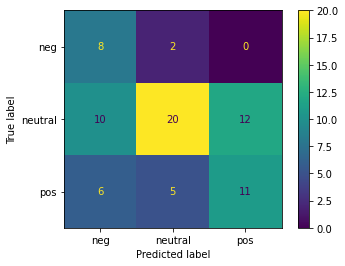

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=net.final_matrix.cpu().numpy(),
                               display_labels=['neg','neutral','pos'])
disp.plot()